In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pylab as plt
import matplotlib
import matplotlib.font_manager as fm

import scipy.sparse

import plotly.offline as py
import plotly.express as px

import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

cf.set_config_file(offline=True, world_readable=False)

try:
    font_location = "HANDotum.ttf"
    font_name = fm.FontProperties(fname = font_location).get_name()
    matplotlib.rc('font', family=font_name)
except:
    print("폰트 임포트 에러")

In [7]:
from pathlib import Path

DATA = Path('.').resolve().parent / 'Data'

In [2]:
rv1 = pd.read_csv("../Data/review1_pre.csv", index_col=[0])
rv1 = rv1.drop_duplicates(['Author', 'BookCode'], keep='first')
rv1 = rv1[~pd.isna(rv1["Author"])]

rv_book_pivot = rv1.pivot(index='Author', columns='BookCode', values='SumRate')
rv_book_pivot = rv_book_pivot.fillna(0)
us_list = rv_book_pivot.index
book_list = rv_book_pivot.columns

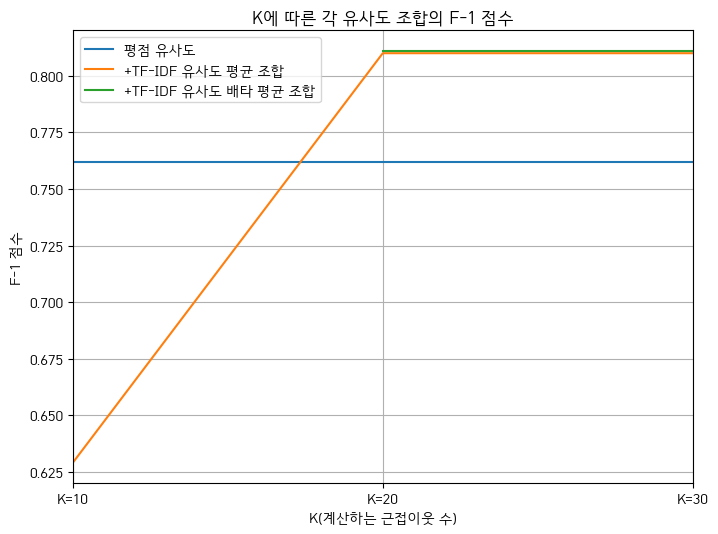

In [5]:
plt.figure(figsize=(8, 6), dpi=100)

plt.subplot(111)

X = np.linspace(0, 2, 3)
f1_norm = [0.762, 0.762, 0.762]
f1_tfidf1 = [0.629, 0.81, 0.81]
f1_tfidf2 = [0.811, 0.811]

plt.plot(X, f1_norm, label="평점 유사도", ls='-')
plt.plot(X, f1_tfidf1, label="+TF-IDF 유사도 평균 조합", ls='-')
plt.plot(X[1:], f1_tfidf2, label="+TF-IDF 유사도 배타 평균 조합", ls='-')

plt.title("K에 따른 각 유사도 조합의 F-1 점수")
plt.legend()
plt.ylabel("F-1 점수")
plt.xlabel("K(계산하는 근접이웃 수)")
plt.xticks([0, 1, 2],
       ['K=10', 'K=20', 'K=30'])
plt.grid(True)
plt.xlim([0, 2])

plt.show()

In [3]:
rv1["SumRate"].iplot(kind="hist", title="리뷰 점수 히스토그램", xTitle="리뷰 점수")

In [4]:
review_grouped_by_book = rv1.groupby("BookCode")
review_grouped_by_book[["Title"]].count().sort_values("Title", ascending=False).iplot(kind="hist", title="책 별 리뷰 건수 히스토그램", xTitle="리뷰건수")

---

In [33]:
# 유사도 로드
sim_norm_csr = scipy.sparse.load_npz(DATA / 'sim_norm.npz')
sim_norm = pd.DataFrame(sim_norm_csr.todense(), index=book_list, columns=book_list)
sim_w2v_csr = scipy.sparse.load_npz(DATA / 'sim_w2v.npz')
sim_w2v = pd.DataFrame(sim_w2v_csr.todense(), index=book_list, columns=book_list)
sim_tfidf_csr = scipy.sparse.load_npz(DATA / 'sim_tfidf.npz')
sim_tfidf = pd.DataFrame(sim_tfidf_csr.todense(), index=book_list, columns=book_list)

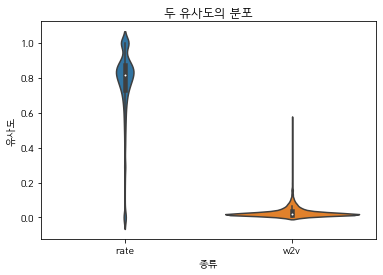

In [44]:
sim_norm_arr = sim_norm.values
df_rate = pd.DataFrame(sim_norm_arr[sim_norm_arr > 0].reshape(-1), columns=["sim"]) 
df_rate["type"] = ["rate"] * len(df_rate)
sim_w2v_arr = sim_w2v.values
df_w2v = pd.DataFrame(sim_w2v_arr[sim_w2v_arr > 0].reshape(-1), columns=["sim"])
df_w2v["type"] = ["w2v"] * len(df_w2v)
df_vis = pd.concat([df_rate, df_w2v])

sns.violinplot(data=df_vis, x="type", y="sim", figsize=(8, 5))
plt.title("두 유사도의 분포")
plt.xlabel("종류")
plt.ylabel("유사도")
plt.show()

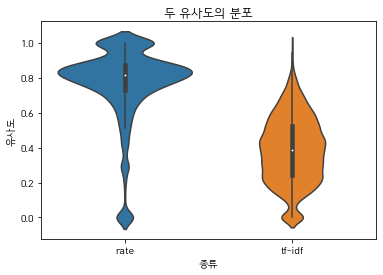

In [40]:
sim_norm_arr = sim_norm.values
df_rate = pd.DataFrame(sim_norm_arr[sim_norm_arr > 0].reshape(-1), columns=["sim"]) 
df_rate["type"] = ["rate"] * len(df_rate)
sim_tfidf_arr = sim_tfidf.values
df_tfidf = pd.DataFrame(sim_tfidf_arr[sim_tfidf_arr > 0].reshape(-1), columns=["sim"])
df_tfidf["type"] = ["tf-idf"] * len(df_tfidf)
df_vis = pd.concat([df_rate, df_tfidf])

sns.violinplot(data=df_vis, x="type", y="sim", figsize=(8, 5))
plt.title("두 유사도의 분포")
plt.xlabel("종류")
plt.ylabel("유사도")
plt.show()

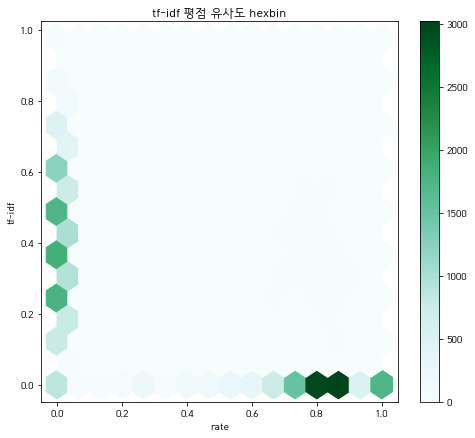

In [41]:
sim_comb = np.append(sim_tfidf.values.reshape((-1, 1)), sim_norm.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(sim_comb, columns=["tf-idf", "rate"])
vis_df = vis_df[(vis_df["rate"] > 0) | (vis_df["tf-idf"] > 0)]
ax = vis_df.plot.hexbin(x='rate', y='tf-idf',
                         gridsize=15, sharex=False, figsize=(8, 7))
ax.set_title("tf-idf 평점 유사도 hexbin")

plt.show()

---

In [ ]:
# 예측 점수 로드
pred_norm_csr = scipy.sparse.load_npz(DATA / 'pred_norm.npz')
pred_norm = pd.DataFrame(pred_norm_csr.todense(), index=us_list, columns=book_list)

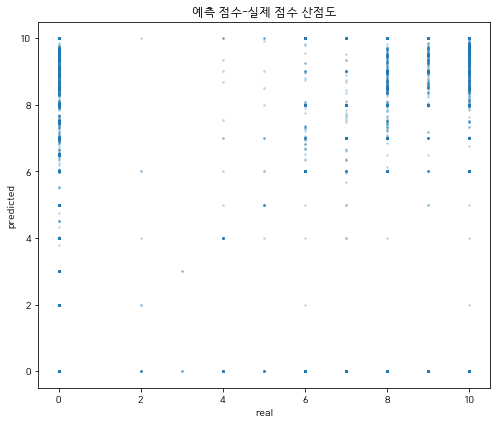

In [74]:
# 시각화
rates_norm = rv_book_pivot.values
rates_norm = rates_norm.reshape((-1, 1))
rates_norm = np.append(rates_norm, pred_norm.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates_norm, columns=["real", "predicted"])
ax = vis_df.plot.scatter(x="real", y="predicted", alpha=0.2, s=3, figsize=(7, 6))

ax.set_title("예측 점수-실제 점수 산점도")
plt.tight_layout()
plt.show()

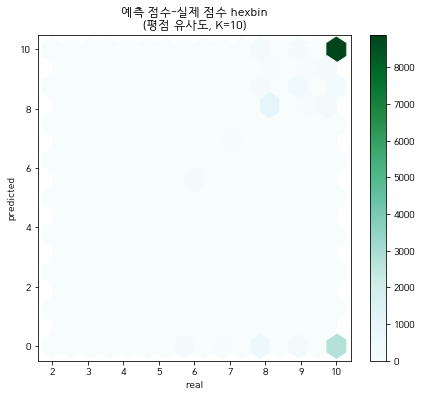

In [78]:
rates_norm = rv_book_pivot.values
rates_norm = rates_norm.reshape((-1, 1))
rates_norm = np.append(rates_norm, pred_norm.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates_norm, columns=["real", "predicted"])

ax = vis_df[(vis_df["real"] > 0)].plot.hexbin(x='real', y='predicted',
                         gridsize=15, sharex=False, figsize=(7, 6))
ax.set_title("예측 점수-실제 점수 hexbin\n(평점 유사도, K=10)")

plt.show()

In [55]:
# 예측 점수 로드
pred_norm_k20_csr = scipy.sparse.load_npz(DATA / 'pred_norm_k20.npz')
pred_norm_k20 = pd.DataFrame(pred_norm_k20_csr.todense(), index=us_list, columns=book_list)

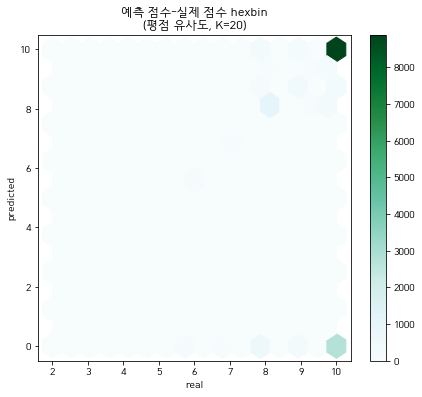

In [63]:
rates_norm = rv_book_pivot.values
rates_norm = rates_norm.reshape((-1, 1))
rates_norm = np.append(rates_norm, pred_norm_k20.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates_norm, columns=["real", "predicted"])

ax = vis_df[(vis_df["real"] > 0)].plot.hexbin(x='real', y='predicted',
                         gridsize=15, sharex=False, figsize=(7, 6))
ax.set_title("예측 점수-실제 점수 hexbin\n(평점 유사도, K=20)")

plt.show()

In [64]:
# 예측 점수 로드
pred_norm_k30_csr = scipy.sparse.load_npz(DATA / 'pred_norm_k30.npz')
pred_norm_k30 = pd.DataFrame(pred_norm_k30_csr.todense(), index=us_list, columns=book_list)

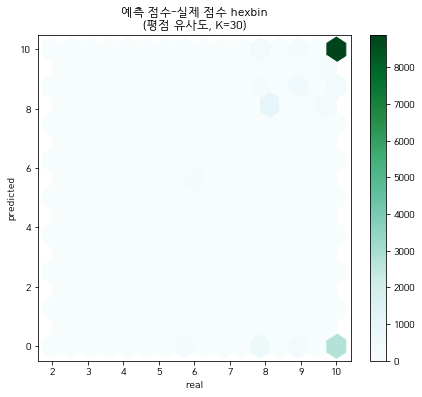

In [65]:
rates_norm = rv_book_pivot.values
rates_norm = rates_norm.reshape((-1, 1))
rates_norm = np.append(rates_norm, pred_norm_k30.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates_norm, columns=["real", "predicted"])

ax = vis_df[(vis_df["real"] > 0)].plot.hexbin(x='real', y='predicted',
                         gridsize=15, sharex=False, figsize=(7, 6))
ax.set_title("예측 점수-실제 점수 hexbin\n(평점 유사도, K=30)")

plt.show()

In [45]:
# 예측 점수 로드
pred_tfidf_csr = scipy.sparse.load_npz(DATA / 'pred_tfidf_comb1.npz')
pred_tfidf = pd.DataFrame(pred_tfidf_csr.todense(), index=us_list, columns=book_list)

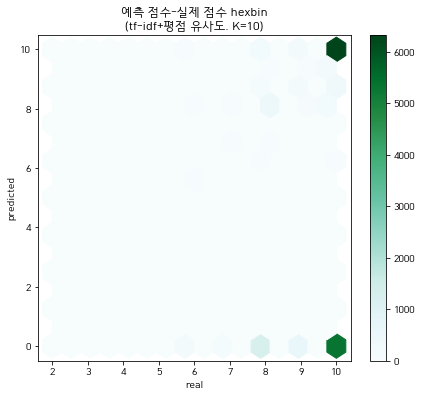

In [79]:
rates_norm = rv_book_pivot.values
rates_norm = rates_norm.reshape((-1, 1))
rates_norm = np.append(rates_norm, pred_tfidf.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates_norm, columns=["real", "predicted"])

ax = vis_df[(vis_df["real"] > 0)].plot.hexbin(x='real', y='predicted',
                         gridsize=15, sharex=False, figsize=(7, 6))
ax.set_title("예측 점수-실제 점수 hexbin\n(tf-idf+평점 유사도. K=10)")

plt.show()

In [67]:
# 예측 점수 로드
pred_tfidf_k20_csr = scipy.sparse.load_npz(DATA / 'pred_tfidf_comb1_k20.npz')
pred_tfidf_k20 = pd.DataFrame(pred_tfidf_k20_csr.todense(), index=us_list, columns=book_list)

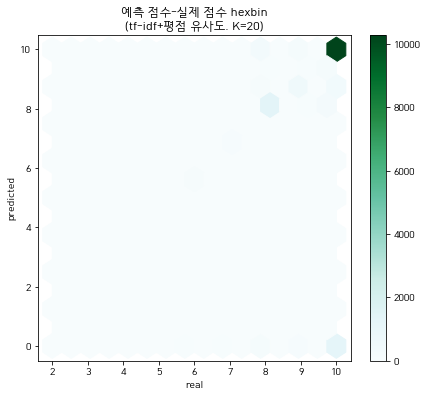

In [68]:
rates_norm = rv_book_pivot.values
rates_norm = rates_norm.reshape((-1, 1))
rates_norm = np.append(rates_norm, pred_tfidf_k20.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates_norm, columns=["real", "predicted"])

ax = vis_df[(vis_df["real"] > 0)].plot.hexbin(x='real', y='predicted',
                         gridsize=15, sharex=False, figsize=(7, 6))
ax.set_title("예측 점수-실제 점수 hexbin\n(tf-idf+평점 유사도. K=20)")

plt.show()

In [69]:
# 예측 점수 로드
pred_tfidf_k30_csr = scipy.sparse.load_npz(DATA / 'pred_tfidf_comb1_k30.npz')
pred_tfidf_k30 = pd.DataFrame(pred_tfidf_k30_csr.todense(), index=us_list, columns=book_list)

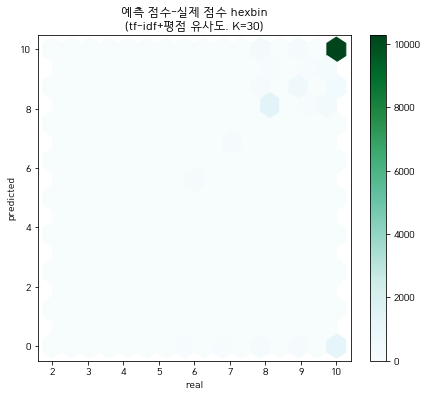

In [71]:
rates_norm = rv_book_pivot.values
rates_norm = rates_norm.reshape((-1, 1))
rates_norm = np.append(rates_norm, pred_tfidf_k30.values.reshape((-1, 1)), axis=1)

vis_df = pd.DataFrame(rates_norm, columns=["real", "predicted"])

ax = vis_df[(vis_df["real"] > 0)].plot.hexbin(x='real', y='predicted',
                         gridsize=15, sharex=False, figsize=(7, 6))
ax.set_title("예측 점수-실제 점수 hexbin\n(tf-idf+평점 유사도. K=30)")

plt.show()